In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import timedelta


In [6]:
# ==============================================================================
# BLACK-SCHOLES MODEL FOR EUROPEAN OPTIONS
# ==============================================================================

def black_scholes_price(S, K, T, r, sigma, option_type):
    """
    Calculates the price of a European option using the Black-Scholes model.

    Args:
        S (float): Current price of the underlying asset.
        K (float): Strike price of the option.
        T (float): Time to expiration in years.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the underlying asset's returns.
        option_type (str): 'call' or 'put'.

    Returns:
        float: The theoretical price of the option. Returns 0 if T <= 0.
    """
    if T <= 0:
        return 0

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type == 'put':
        price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    else:
        raise ValueError("Invalid option type. Must be 'call' or 'put'.")

    return price


In [19]:
def binomial_option_price(S, K, T, r, sigma, option_type, steps=100):
    """
    Calculates the price of a European option using the Binomial Tree model.
    """
    if T <= 0:
        return max(0, S - K) if option_type == 'call' else max(0, K - S)

    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    ST = np.zeros(steps + 1)
    for i in range(steps + 1):
        ST[i] = S * (u**(steps - i)) * (d**i)

    # Initialize option values at maturity
    option_values = np.zeros(steps + 1)
    if option_type == 'call':
        option_values = np.maximum(0, ST - K)
    else: # put
        option_values = np.maximum(0, K - ST)
        
    # Step back through the tree
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            option_values[j] = np.exp(-r * dt) * (q * option_values[j] + (1 - q) * option_values[j + 1])
            
    return option_values[0]


In [7]:
# ==============================================================================
# DATA FETCHING AND PREPARATION FROM CSV
# ==============================================================================

def get_data_from_csv(csv_filepath):
    """
    Loads historical stock data from a CSV file and calculates technical indicators.
    
    NOTE: Your CSV file must contain columns named 'Date', 'Open', 'High', 'Low', 'Close'.
    The 'Date' column should be in a format that pandas can recognize (e.g., 'YYYY-MM-DD').

    Args:
        csv_filepath (str): The path to the CSV file.

    Returns:
        pd.DataFrame: A DataFrame containing the stock's OHLCV data plus
                      calculated volatility and moving averages.
    """
    print(f"Loading data from {csv_filepath}...")
    try:
        df = pd.read_csv(csv_filepath, parse_dates=['Date'], index_col='Date')
    except FileNotFoundError:
        raise FileNotFoundError(f"Error: The file '{csv_filepath}' was not found.")
    except Exception as e:
        raise Exception(f"An error occurred while reading the CSV file: {e}")

    if df.empty:
        raise ValueError(f"No data loaded from CSV. The file might be empty or in the wrong format.")

    # Ensure required columns exist
    required_cols = ['Open', 'High', 'Low', 'Close']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"CSV file must contain the following columns: {required_cols}")

    # Calculate log returns for volatility
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Calculate rolling historical volatility (annualized)
    df['volatility'] = df['log_return'].rolling(window=21).std() * np.sqrt(252)

    # Calculate moving averages for strategy triggers
    df['SMA20'] = df['Close'].rolling(window=20).mean()
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    
    # Calculate long-term average volatility for Strategy 3
    df['volatility_long_avg'] = df['volatility'].rolling(window=100).mean()

    # Drop rows with NaN values resulting from rolling calculations
    df.dropna(inplace=True)

    print("Data loading and preparation complete.")
    return df


In [8]:
def generate_options_chain(timestamp, underlying_price, volatility, risk_free_rate):
    """
    Simulates a realistic options chain for a given day.
    In a real-world scenario, you would use a provider for historical options data.

    Args:
        timestamp (datetime): The current date.
        underlying_price (float): The current price of the stock.
        volatility (float): The current annualized volatility.
        risk_free_rate (float): The risk-free interest rate.

    Returns:
        list: A list of dictionaries, where each dictionary represents an option.
    """
    options_chain = []
    # Generate options with a standard 30-day expiry
    expiry_date = timestamp + timedelta(days=30)
    time_to_expiry = (expiry_date - timestamp).days / 365.25

    # Generate strikes from 20% below to 20% above the current price
    for strike_multiplier in np.arange(0.8, 1.21, 0.05):
        strike_price = round(underlying_price * strike_multiplier / 5) * 5 # Round to nearest 5

        # Calculate call and put prices using Black-Scholes
        call_price = black_scholes_price(underlying_price, strike_price, time_to_expiry, risk_free_rate, volatility, 'call')
        put_price = black_scholes_price(underlying_price, strike_price, time_to_expiry, risk_free_rate, volatility, 'put')

        # Add to the chain
        options_chain.append({
            "strike": strike_price, "expiry": expiry_date, "option_type": "call", "price": call_price
        })
        options_chain.append({
            "strike": strike_price, "expiry": expiry_date, "option_type": "put", "price": put_price
        })
        
    return options_chain


In [9]:
# ==============================================================================
# GLOBAL STATE & HELPER
# ==============================================================================
# These variables will hold the state of our portfolio during a backtest.

INITIAL_CAPITAL = 100000.0
portfolio = {}

def reset_portfolio_state():
    """Resets the portfolio to its initial state before a new backtest."""
    global portfolio
    portfolio = {
        "cash": INITIAL_CAPITAL,
        "stocks": [],  # List of dicts: {"buy_price": float, "quantity": int}
        "options": [], # List of dicts: {"strike", "expiry", "type", "qty", "entry_price", "direction"}
        "trade_log": [],
        "portfolio_values": [] # Tracks portfolio value over time
    }
    print("\n--- Portfolio state has been reset. ---")
    print(f"Starting Capital: ${portfolio['cash']:.2f}")


In [18]:

# ==============================================================================
# TRADING STRATEGIES
# ==============================================================================

def strategy_covered_call(data, options_chain):
    """
    Strategy 1: Covered Call
    - If we own at least 100 shares of stock, we sell an out-of-the-money (OTM)
      call option to generate income.
    - This is a conservative strategy for income generation.
    """
    actions = []
    total_stock_qty = sum(s['quantity'] for s in portfolio['stocks'])
    
    # Check if we have at least 100 shares to write a call against
    if total_stock_qty >= 100:
        # Find the number of calls already sold
        sold_calls_qty = sum(o['quantity'] for o in portfolio['options'] if o['option_type'] == 'call' and o['direction'] == 'short')
        
        # Check if we can sell more calls (1 call per 100 shares)
        if (total_stock_qty // 100) > sold_calls_qty:
            # Find the first OTM call option (strike > current price)
            otm_call = min(
                (opt for opt in options_chain if opt['option_type'] == 'call' and opt['strike'] > data['Close']),
                key=lambda x: x['strike'],
                default=None
            )
            if otm_call:
                actions.append({
                    "asset_type": "option", "action": "sell", "option_type": "call",
                    "strike": otm_call['strike'], "expiry": otm_call['expiry'],
                    "quantity": 1
                })
    # As a simple underlying strategy, buy the stock if cash is available
    elif portfolio['cash'] > data['Close'] * 100:
         actions.append({"asset_type": "stock", "action": "buy", "quantity": 100})

    return actions

def strategy_protective_put(data, options_chain):
    """
    Strategy 2: Protective Put
    - If we own stock and the trend turns bearish (20-day SMA crosses below
      50-day SMA), we buy a protective put to hedge against a downturn.
    - This is a risk management strategy.
    """
    actions = []
    total_stock_qty = sum(s['quantity'] for s in portfolio['stocks'])
    has_put_protection = any(o['option_type'] == 'put' and o['direction'] == 'long' for o in portfolio['options'])

    # Condition to buy stock (simple holding strategy)
    if total_stock_qty == 0 and portfolio['cash'] > data['Close'] * 100:
        actions.append({"asset_type": "stock", "action": "buy", "quantity": 100})
        
    # Bearish signal: short-term moving average crosses below long-term
    if data['SMA20'] < data['SMA50'] and total_stock_qty >= 100 and not has_put_protection:
        # Find the nearest OTM put to buy as insurance
        otm_put = max(
            (opt for opt in options_chain if opt['option_type'] == 'put' and opt['strike'] < data['Close']),
            key=lambda x: x['strike'],
            default=None
        )
        if otm_put and portfolio['cash'] >= otm_put['price'] * 100:
             actions.append({
                "asset_type": "option", "action": "buy", "option_type": "put",
                "strike": otm_put['strike'], "expiry": otm_put['expiry'],
                "quantity": 1 # 1 put for every 100 shares
            })
            
    return actions

def strategy_volatility_mean_reversion(data, options_chain):
    """
    Strategy 3: Short Straddle on High Volatility
    - If current volatility is significantly higher than its long-term average,
      we expect it to revert down. We can profit by selling volatility.
    - We sell an at-the-money (ATM) straddle (sell call + sell put).
    """
    actions = []
    # Trigger when current volatility is 25% higher than its 100-day average
    if data['volatility'] > data['volatility_long_avg'] * 1.25:
        # Check if we already have a short straddle position
        has_short_straddle = any(o['direction'] == 'short' for o in portfolio['options'])
        
        if not has_short_straddle:
            # Find the ATM strike (closest to current price)
            atm_strike = min(options_chain, key=lambda x: abs(x['strike'] - data['Close']))['strike']
            atm_call = next((opt for opt in options_chain if opt['strike'] == atm_strike and opt['option_type'] == 'call'), None)
            atm_put = next((opt for opt in options_chain if opt['strike'] == atm_strike and opt['option_type'] == 'put'), None)

            if atm_call and atm_put:
                print(f"High Volatility Alert! Current: {data['volatility']:.3f}, Avg: {data['volatility_long_avg']:.3f}. Selling Straddle.")
                # Sell Call
                actions.append({
                    "asset_type": "option", "action": "sell", "option_type": "call",
                    "strike": atm_call['strike'], "expiry": atm_call['expiry'], "quantity": 1
                })
                # Sell Put
                actions.append({
                    "asset_type": "option", "action": "sell", "option_type": "put",
                    "strike": atm_put['strike'], "expiry": atm_put['expiry'], "quantity": 1
                })
                
    return actions


In [11]:
# ==============================================================================
# BACKTEST EXECUTION ENGINE
# ==============================================================================

def run_backtest(market_data, strategy_function, risk_free_rate):
    """
    Executes the backtest for a given dataset and strategy.

    Args:
        market_data (pd.DataFrame): The historical stock and indicator data.
        strategy_function (function): The strategy function to execute.
        risk_free_rate (float): The risk-free interest rate.
    """
    global portfolio
    reset_portfolio_state()
    
    timestamps = []

    for timestamp, data in market_data.iterrows():
        # Get current market conditions
        close_price = data['Close']
        volatility = data['volatility']

        # --- Step 0: Generate today's options chain ---
        options_chain = generate_options_chain(timestamp, close_price, volatility, risk_free_rate)
        
        # --- Step 1: Handle Option Expiries & Realize PnL ---
        # Options are cash-settled at expiry based on intrinsic value.
        realized_pnl_today = 0
        active_options = []
        for opt in portfolio['options']:
            if opt['expiry'].date() == timestamp.date():
                intrinsic_value = 0
                if opt['option_type'] == 'call':
                    intrinsic_value = max(0, close_price - opt['strike'])
                elif opt['option_type'] == 'put':
                    intrinsic_value = max(0, opt['strike'] - close_price)
                
                payout = intrinsic_value * opt['quantity'] * 100
                
                if opt['direction'] == 'long':
                    pnl = payout - (opt['entry_price'] * opt['quantity'] * 100)
                    portfolio['cash'] += payout
                else: # short
                    pnl = (opt['entry_price'] * opt['quantity'] * 100) - payout
                    portfolio['cash'] -= payout # Payout to the buyer

                realized_pnl_today += pnl
                portfolio['trade_log'].append((timestamp, f"EXPIRE {opt['direction'].upper()} {opt['option_type'].upper()}", f"Strike {opt['strike']}", f"PnL: {pnl:.2f}"))
            else:
                active_options.append(opt)
        portfolio['options'] = active_options


        # --- Step 2: Call Strategy ---
        actions = strategy_function(data, options_chain)

        # --- Step 3: Execute Actions ---
        for action in actions:
            if action['asset_type'] == 'stock':
                price = close_price
                qty = action['quantity']
                cost = qty * price
                if action['action'] == 'buy' and portfolio['cash'] >= cost:
                    portfolio['cash'] -= cost
                    portfolio['stocks'].append({'buy_price': price, 'quantity': qty})
                    portfolio['trade_log'].append((timestamp, "BUY STOCK", qty, f"@{price:.2f}"))
                elif action['action'] == 'sell' and portfolio['stocks']:
                    # Simple FIFO sell logic
                    sold_qty = 0
                    remaining_qty = qty
                    new_stocks_list = []
                    for lot in portfolio['stocks']:
                        if remaining_qty > 0:
                            if lot['quantity'] <= remaining_qty:
                                portfolio['cash'] += lot['quantity'] * price
                                remaining_qty -= lot['quantity']
                            else:
                                portfolio['cash'] += remaining_qty * price
                                new_stocks_list.append({'buy_price': lot['buy_price'], 'quantity': lot['quantity'] - remaining_qty})
                                remaining_qty = 0
                        else:
                            new_stocks_list.append(lot)
                    portfolio['stocks'] = new_stocks_list
                    portfolio['trade_log'].append((timestamp, "SELL STOCK", qty, f"@{price:.2f}"))

            elif action['asset_type'] == 'option':
                opt_details = next((opt for opt in options_chain if opt['strike'] == action['strike'] and opt['expiry'] == action['expiry'] and opt['option_type'] == action['option_type']), None)
                if opt_details:
                    price = opt_details['price']
                    qty = action['quantity']
                    premium = qty * price * 100
                    direction = "long" if action["action"] == "buy" else "short"

                    if direction == 'long' and portfolio['cash'] >= premium:
                        portfolio['cash'] -= premium
                        portfolio['options'].append({**action, "direction": direction, "entry_price": price})
                        portfolio['trade_log'].append((timestamp, f"BUY {qty} {action['option_type'].upper()}", f"Strike {action['strike']}", f"@{price:.2f}"))
                    elif direction == 'short':
                        portfolio['cash'] += premium
                        portfolio['options'].append({**action, "direction": direction, "entry_price": price})
                        portfolio['trade_log'].append((timestamp, f"SELL {qty} {action['option_type'].upper()}", f"Strike {action['strike']}", f"@{price:.2f}"))

        # --- Step 4: Track Portfolio Value (Mark-to-Market) ---
        stock_value = sum(s['quantity'] * close_price for s in portfolio['stocks'])
        
        option_value = 0
        for opt in portfolio['options']:
            # Mark-to-market using the theoretical price for that day
            time_to_expiry = (opt['expiry'] - timestamp).days / 365.25
            current_opt_price = black_scholes_price(close_price, opt['strike'], time_to_expiry, risk_free_rate, volatility, opt['option_type'])
            
            if opt['direction'] == 'long':
                option_value += current_opt_price * opt['quantity'] * 100
            else: # short
                option_value -= current_opt_price * opt['quantity'] * 100

        total_value = portfolio['cash'] + stock_value + option_value
        portfolio['portfolio_values'].append(total_value)
        timestamps.append(timestamp)

    # --- Final Portfolio Output ---
    print("\n--- Backtest Complete ---")
    final_value = portfolio['portfolio_values'][-1]
    total_pnl = final_value - INITIAL_CAPITAL
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Profit/Loss: ${total_pnl:,.2f}")
    print(f"Final Cash: ${portfolio['cash']:.2f}")
    print(f"Final Stock Holdings: {sum(s['quantity'] for s in portfolio['stocks'])} shares")
    print(f"Final Open Option Positions: {len(portfolio['options'])}")
    
    # --- Plotting ---
    plt.figure(figsize=(14, 7))
    plt.plot(timestamps, portfolio['portfolio_values'], label="Portfolio Value")
    # Add a buy-and-hold benchmark for comparison
    buy_and_hold = (market_data['Close'] / market_data['Close'].iloc[0]) * INITIAL_CAPITAL
    plt.plot(market_data.index, buy_and_hold, label="Buy and Hold Benchmark", linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.title(f"Backtest Performance: {strategy_function.__name__}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Loading data from AAPL.csv...
Data loading and preparation complete.

RUNNING BACKTEST FOR: strategy_covered_call

--- Portfolio state has been reset. ---
Starting Capital: $100000.00

--- Backtest Complete ---
Final Portfolio Value: $110,604.01
Total Profit/Loss: $10,604.01
Final Cash: $91490.98
Final Stock Holdings: 100 shares
Final Open Option Positions: 1


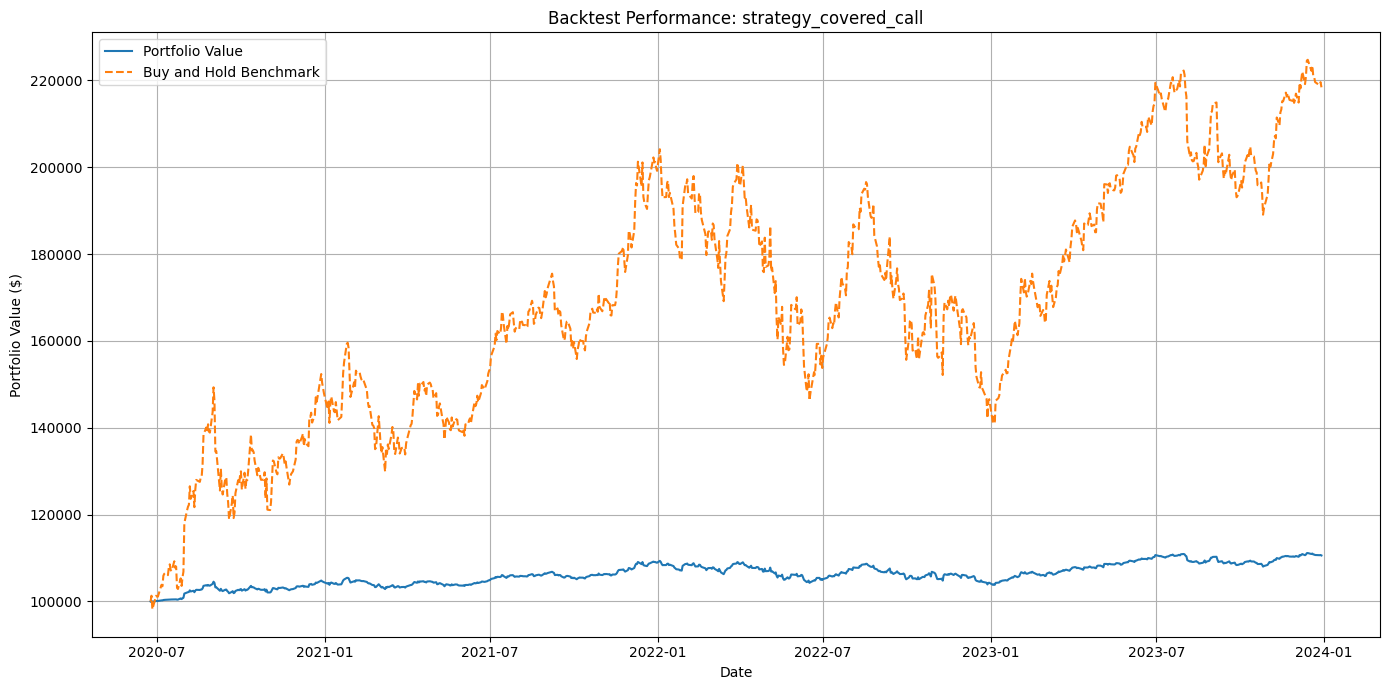


RUNNING BACKTEST FOR: strategy_protective_put

--- Portfolio state has been reset. ---
Starting Capital: $100000.00
An error occurred: strategy_protective_put() missing 1 required positional argument: 'portfolio'


In [17]:

# ==============================================================================
# MAIN EXECUTION BLOCK
# ==============================================================================

if __name__ == '__main__':
   
    
    RISK_FREE_RATE = 0.015  

    # --- Load Data from CSV ---
    try:
        market_data_df = get_data_from_csv("AAPL.csv")

        # --- Run Backtests for Each Strategy ---
        strategies = [
            strategy_covered_call,
            strategy_protective_put,
            strategy_volatility_mean_reversion
        ]

        for strategy in strategies:
            print("\n" + "="*50)
            print(f"RUNNING BACKTEST FOR: {strategy.__name__}")
            print("="*50)
            run_backtest(market_data_df, strategy, RISK_FREE_RATE)

        #--- Optional: Display Trade Log for the last run ---
        print("\n--- Last Trade Log ---")
        for log_entry in portfolio['trade_log'][-20:]: # Last 20 trades
            print(log_entry)

    except Exception as e:
        print(f"An error occurred: {e}")
